In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import glob
from glob import glob
import re
import tkinter as tk
from tkinter import filedialog
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
import statistics
import scipy.stats
from scipy.stats import sem
import statsmodels.api as sm
import statistics
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%config InlineBackend.figure_format = 'retina'# this increases sharpness of figure display 
colors = ['#0E86D4','#d7301f'] #virgin/D18 (use #FAA41F for D10)

In [2]:
export_path = '/Volumes/lab-kohlj/home/shared/projects/VolumeProject/plots' 

### 0. Notes
• QuPath detections were performed on (1) MPOA subregions (MPN, MPO, ADP, PS, PD); (2) Alp5, (3) MOs5 <br>
• detections happened to be performed separately for MPOA (round 1) and Alp5/MOs5 (round 2); turns out that MPOA detections are also in the Alp5/MOs5 files, but since detections were not run on a few sections in which Alp5/MOs5 was damaged (but MPOA intact), will use detections from round 1 for now. <br>
• detection files contain all detected neurons and their areas (--> cell size) <br>
• annotation files (_annot_) contain total number of detected neurons per area, as well as the area size

### 1. Import the data (unmixed)

In [3]:
# make a function which gives the difference between two lists --> to get all files which don't contain *annot*
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

#### 1.1 Text files
Read in all text files from parent 'detection' directory for detection analyses

In [4]:
# make lists of filenames for the two different types of files (annotations and detection files)
filenames = glob('/Volumes/lab-kohlj/home/shared/projects/VolumeProject/Neurotrace/original/detection/text_files/*.txt')
filenames_ann = glob('/Volumes/lab-kohlj/home/shared/projects/VolumeProject/Neurotrace/original/detection/text_files/*annot*.txt')
filenames_det = Diff(filenames, filenames_ann)

In [5]:
# display(filenames_ann)

In [6]:
#read the files into pandas, then concatenate them (this creates a dataframe)
ann_list = [pd.read_table(file) for file in filenames_ann]
df_ann = pd.concat(ann_list)

In [7]:
#df_ann.head(20)

In [8]:
pd.set_option('display.max_rows',10)
# display(df_ann)

## 2. MPOA Neuron density analyses
#### subsetting MPOA ROIs density data 

In [9]:
# remove row(s) with zero values in Detections
df_ann['Num Detections'] = df_ann['Num Detections'].replace(np.nan, 0)
df_ann = df_ann[df_ann['Num Detections'] !=0]

# add a State column
df_ann.loc[df_ann['Image'].str.contains('V') & df_ann['Image'].str.contains('.tif'), 'State'] = 'Virgin'
df_ann.loc[df_ann['Image'].str.contains('P') & df_ann['Image'].str.contains('.tif'), 'State'] = 'Pregnant'

# only keep MPOA subregions
mpoa = ['ADP', 'PS', 'MPN', 'MPO']
df_ann = df_ann[(df_ann['Class'].isin(mpoa))]

In [10]:
# add new column where area is in mm2
df_ann['Area_mm2'] = df_ann['Area µm^2'] / 1e6
# display(df_ann)

# add new neuron density column
df_ann['neuron_density'] = df_ann['Num Detections'] / df_ann['Area_mm2']

# add new sample ID column
df_ann.loc[df_ann['Image'].str.contains('1V'), 'ID'] = '1V'
df_ann.loc[df_ann['Image'].str.contains('2V'), 'ID'] = '2V'
df_ann.loc[df_ann['Image'].str.contains('3V'), 'ID'] = '3V'
df_ann.loc[df_ann['Image'].str.contains('4P'), 'ID'] = '4P'
df_ann.loc[df_ann['Image'].str.contains('5P'), 'ID'] = '5P'
df_ann.loc[df_ann['Image'].str.contains('6P'), 'ID'] = '6P'
df_ann.loc[df_ann['Image'].str.contains('1P'), 'ID'] = '1P'
df_ann.loc[df_ann['Image'].str.contains('2P'), 'ID'] = '2P'
df_ann.loc[df_ann['Image'].str.contains('3P'), 'ID'] = '3P'
df_ann.loc[df_ann['Image'].str.contains('4V'), 'ID'] = '4V'
df_ann.loc[df_ann['Image'].str.contains('5V'), 'ID'] = '5V'
df_ann.loc[df_ann['Image'].str.contains('6V'), 'ID'] = '6V'
df_ann.loc[df_ann['Image'].str.contains('7V'), 'ID'] = '7V'
df_ann.loc[df_ann['Image'].str.contains('7P'), 'ID'] = '7P'
df_ann.loc[df_ann['Image'].str.contains('8V'), 'ID'] = '8V'
df_ann.loc[df_ann['Image'].str.contains('8P'), 'ID'] = '8P'


In [11]:
df_ann2 = df_ann.groupby(['Class','ID', 'State']).agg({'neuron_density': 'mean'})
df_ann2.columns = ['mean_neuron_density']
df_ann2 = df_ann2.reset_index()
# df_ann2

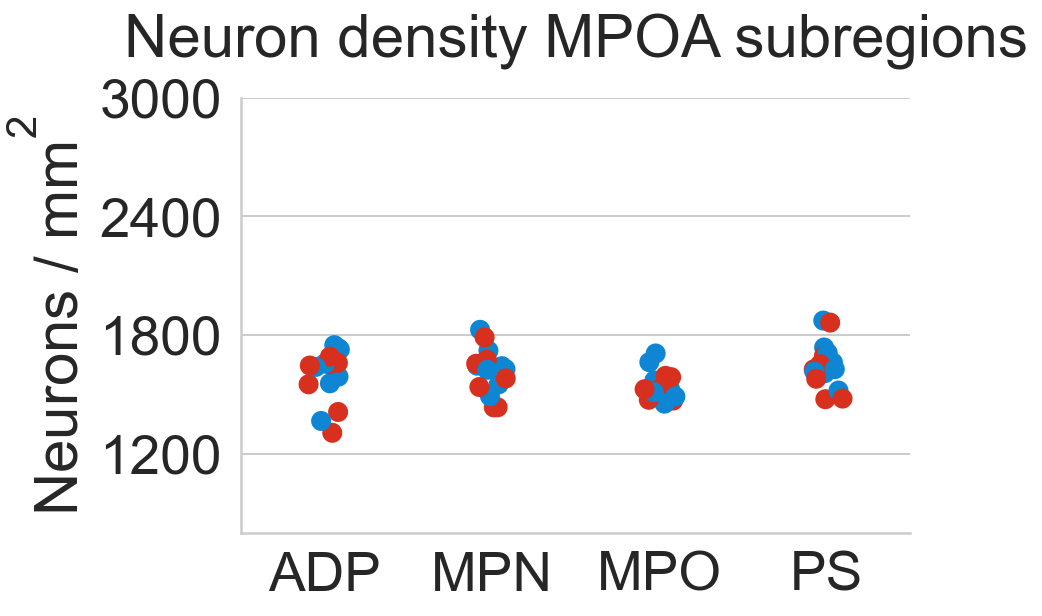

In [12]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.set(font_scale=2.5) 
sns.set_style("whitegrid")
g = sns.stripplot(data=df_ann2, x="Class", y="mean_neuron_density", hue="State", palette=colors, size=10, dodge=False)
g.set_title('Neuron density MPOA subregions', pad=20)
g.set_xlabel('')
g.set_ylabel('Neurons / $\mathregular{mm^{2}}$')
g.legend_.remove()
sns.despine() 
plt.ylim(800, 3000)
g.yaxis.set_major_locator(plt.MaxNLocator(4));

filename = os.path.join(export_path, 'neuron_density_MPOA_subregions_round2.pdf')
plt.savefig(filename, dpi=300, transparent=True, bbox_inches = "tight")

In [13]:
# group by individual and calculate average neuron density across all areas for each individual; flatten and reset index
df_ann3 = df_ann.groupby(['ID', 'State']).agg({'neuron_density': 'mean'})
df_ann3.columns = ['mean_neuron_density']
df_ann3 = df_ann3.reset_index()
df_ann3

,ID,State,mean_neuron_density
0,1P,Pregnant,1713.346064
1,1V,Virgin,1447.613809
2,2P,Pregnant,1601.200435
3,3P,Pregnant,1633.681028
4,3V,Virgin,1494.723458
...,...,...,...
10,6V,Virgin,1517.274693
11,7P,Pregnant,1588.969642
12,7V,Virgin,1730.818036
13,8P,Pregnant,1561.257893


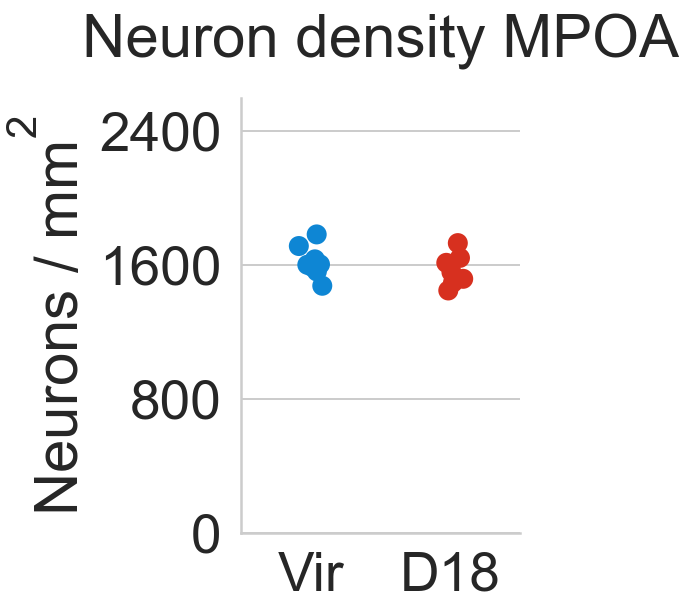

In [14]:
sns.set(rc={"figure.figsize": (2.5, 4)})
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
g = sns.stripplot(data=df_ann3, x="State", y="mean_neuron_density", palette = colors, size=10)
g.set_xticklabels(['Vir','D18'])
g.set_title('Neuron density MPOA', pad=20)
g.set_xlabel('')
g.set_ylabel('Neurons / $\mathregular{mm^{2}}$')
sns.despine() 
plt.ylim(0, 2600)
g.yaxis.set_major_locator(plt.MaxNLocator(4));

filename = os.path.join(export_path, 'neuron_density_panMPOA_round2.pdf')
plt.savefig(filename, dpi=300, transparent=True, bbox_inches = "tight")

## 3. Cortex density analyses 
#### Reading in text files from AIp5_MOp5 directory and excluding cortex data from parent 'detection' directory

In [15]:
filenames_cortex_ann = glob('/Volumes/lab-kohlj/home/shared/projects/VolumeProject/Neurotrace/original/detection/text_files/*annot*.txt')
filesnames_cortex2_ann = glob('/Volumes/lab-kohlj/home/shared/projects/VolumeProject/Neurotrace/original/detection/text_files/Alp5_MOs5/*annot*.txt')

In [16]:
#read the files into pandas, then concatenate them (this creates a dataframe)
cortex_ann_list = [pd.read_table(file) for file in filenames_cortex_ann]
df_cortex_ann = pd.concat(cortex_ann_list)

#### Extract cortex info from June batch annot files only
we can tell apart these files because in the 'Image' column, they do not have 'VL' in the name

In [17]:
# only keep June batch cortex annot
df_cortex_ann = df_cortex_ann[df_cortex_ann["Image"].str.contains("VL-") == False]

In [18]:
df_cortex_ann['Image'].str.contains('VL')

0      False
1      False
2      False
3      False
4      False
       ...  
160    False
161    False
162    False
163    False
164    False
Name: Image, Length: 9514, dtype: bool

In [19]:
# display(df_cortex_ann)

In [20]:
# create df for Alp5_MOs5 annot files - these will have 'VL' in image column, this is fine
cortex2_ann_list = [pd.read_table(file) for file in filesnames_cortex2_ann]
df_cortex2_ann = pd.concat(cortex2_ann_list)
# display(df_cortex2_ann)

In [21]:
# combine dataframes
main_cortex_df = pd.concat([df_cortex_ann, df_cortex2_ann])
main_cortex_df.reset_index(drop = True)

,Image,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Allen ID,Parent Allen ID,Side,Num Detections,Area µm^2,Perimeter µm
0,6V-Scan2.tif,"Primary somatosensory area, unassigned, layer 2/3",SSp-un2/3,"Primary somatosensory area, unassigned",Geometry,5582.6,1477.60,182305697,182305689,0,0.0,183072.2,2397.2
1,6V-Scan2.tif,"Primary somatosensory area, nose, layer 4",SSp-n4,"Primary somatosensory area, nose",Geometry,5384.9,2072.40,654,353,0,0.0,438406.8,5360.4
2,6V-Scan2.tif,"Primary motor area, Layer 5",MOp5,Primary motor area,Geometry,5115.3,1260.20,648,985,0,0.0,715506.2,5667.2
3,6V-Scan2.tif,"Primary somatosensory area, upper limb, layer 1",SSp-ul1,"Primary somatosensory area, upper limb",Geometry,5047.5,971.94,450,369,0,0.0,274107.1,4706.1
4,6V-Scan2.tif,"Primary somatosensory area, unassigned, layer 6a",SSp-un6a,"Primary somatosensory area, unassigned",Geometry,5196.1,2113.70,182305709,182305689,0,0.0,41844.1,2016.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12756,VL-6P_section3.ome.tif,"corpus callosum, body",ccb,corpus callosum,Geometry,4744.8,5232.70,484682516,776,0,0.0,957734.7,16822.0
12757,VL-6P_section3.ome.tif,Brain stem,BS,Basic cell groups and regions,Geometry,1709.8,4557.90,343,8,0,1699.0,2402988.7,10751.1
12758,VL-6P_section3.ome.tif,Periventricular region,PVR,Hypothalamus,Geometry,1681.9,4533.10,141,1097,0,1107.0,1300502.9,14177.7
12759,VL-6P_section3.ome.tif,optic nerve,IIn,cranial nerves,Geometry,1029.5,4433.20,848,967,0,0.0,320213.9,3231.8


In [22]:
# remove row(s) with zero values in Detections
#main_cortex_df['Num Detections'] = df_ann['Num Detections'].replace(np.nan, 0)
main_cortex_df = main_cortex_df[main_cortex_df['Num Detections'] !=0]

# add a State column
main_cortex_df.loc[main_cortex_df['Image'].str.contains('V') & main_cortex_df['Image'].str.contains('.tif'), 'State'] = 'Virgin'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('P') & main_cortex_df['Image'].str.contains('.tif'), 'State'] = 'Pregnant'

# only keep AIp5 and MOs5 subregions
cortex = ['AIp5', 'MOs5']
main_cortex_df = main_cortex_df[(main_cortex_df['Class'].isin(cortex))]

In [23]:
main_cortex_df['Class'].str.contains('AIp5')

107    False
144     True
26     False
102     True
37     False
       ...  
90      True
155    False
116    False
167     True
63     False
Name: Class, Length: 142, dtype: bool

In [24]:
main_cortex_df


,Image,Name,Class,Parent,ROI,Centroid X µm,Centroid Y µm,Allen ID,Parent Allen ID,Side,Num Detections,Area µm^2,Perimeter µm,State
107,6V-Scan2.tif,"Secondary motor area, layer 5",MOs5,Secondary motor area,Geometry,5192.2,1082.2,767,993,0,569.0,403267.0,3876.0,Virgin
144,6V-Scan2.tif,"Agranular insular area, posterior part, layer 5",AIp5,"Agranular insular area, posterior part",Geometry,4739.9,4797.1,344,111,0,278.0,222676.8,2717.1,Virgin
26,7V-Scan4.tif,"Secondary motor area, layer 5",MOs5,Secondary motor area,Geometry,5010.4,1385.4,767,993,0,931.0,615537.6,4854.5,Virgin
102,7V-Scan4.tif,"Agranular insular area, posterior part, layer 5",AIp5,"Agranular insular area, posterior part",Geometry,5011.2,5132.7,344,111,0,358.0,277731.3,3152.5,Virgin
37,4V-section6.tif,"Secondary motor area, layer 5",MOs5,Secondary motor area,Geometry,6072.9,1549.0,767,993,0,622.0,415098.0,3967.4,Virgin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,VL-5P_section1.ome.tif,"Agranular insular area, posterior part, layer 5",AIp5,"Agranular insular area, posterior part",Geometry,2942.0,5058.2,344,111,0,370.0,231302.6,2874.0,Pregnant
155,VL-5P_section1.ome.tif,"Secondary motor area, layer 5",MOs5,Secondary motor area,Geometry,6128.7,4555.1,767,993,0,734.0,472465.0,4218.0,Pregnant
116,VL-1V_section3.ome.tif,"Secondary motor area, layer 5",MOs5,Secondary motor area,Geometry,5756.5,3488.8,767,993,0,725.0,484108.3,4345.6,Virgin
167,VL-1V_section3.ome.tif,"Agranular insular area, posterior part, layer 5",AIp5,"Agranular insular area, posterior part",Geometry,2846.2,4368.6,344,111,0,380.0,237413.7,2898.4,Virgin


In [25]:
# add new column where area is in mm2
main_cortex_df['Area_mm2'] = main_cortex_df['Area µm^2'] / 1e6

# add new neuron density column
main_cortex_df['neuron_density'] = main_cortex_df['Num Detections'] / main_cortex_df['Area_mm2']

# add new sample ID column
main_cortex_df.loc[main_cortex_df['Image'].str.contains('1V'), 'ID'] = '1V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('2V'), 'ID'] = '2V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('3V'), 'ID'] = '3V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('4P'), 'ID'] = '4P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('5P'), 'ID'] = '5P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('6P'), 'ID'] = '6P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('1P'), 'ID'] = '1P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('2P'), 'ID'] = '2P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('3P'), 'ID'] = '3P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('4V'), 'ID'] = '4V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('5V'), 'ID'] = '5V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('6V'), 'ID'] = '6V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('7V'), 'ID'] = '7V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('7P'), 'ID'] = '7P'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('8V'), 'ID'] = '8V'
main_cortex_df.loc[main_cortex_df['Image'].str.contains('8P'), 'ID'] = '8P'


In [26]:
cortex_ann2 = main_cortex_df.groupby(['Class','ID', 'State']).agg({'neuron_density': 'mean'})
cortex_ann2.columns = ['mean_neuron_density']
cortex_ann2 = cortex_ann2.reset_index()
cortex_ann2

,Class,ID,State,mean_neuron_density
0,AIp5,1P,Pregnant,1529.357696
1,AIp5,1V,Virgin,1517.548484
2,AIp5,2P,Pregnant,1459.456261
3,AIp5,3P,Pregnant,1476.967340
4,AIp5,3V,Virgin,1678.901969
...,...,...,...,...
25,MOs5,6V,Virgin,1503.859541
26,MOs5,7P,Pregnant,1431.314242
27,MOs5,7V,Virgin,1477.625022
28,MOs5,8P,Pregnant,1547.541007


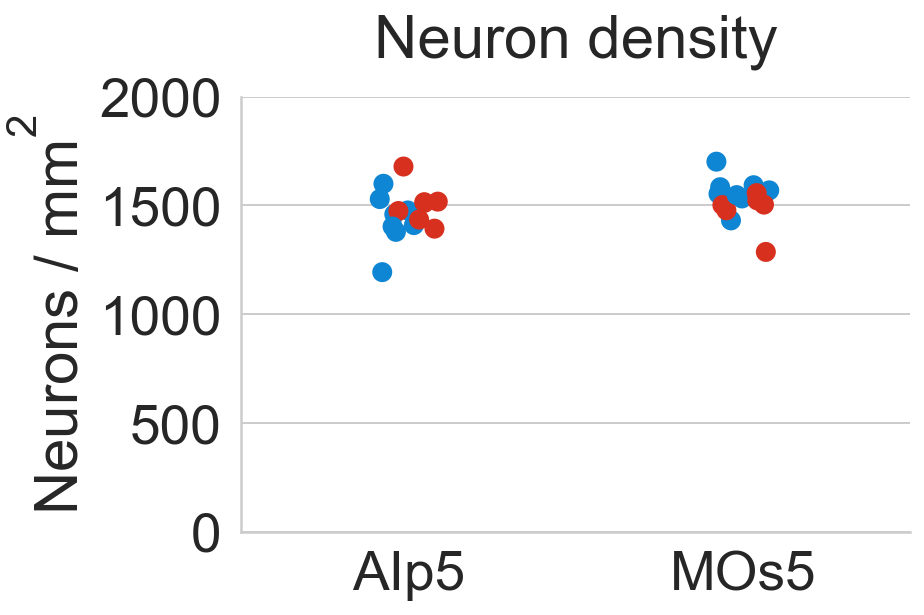

In [27]:
# plotting 
sns.set(rc={"figure.figsize": (6, 4)})
sns.set(font_scale=2.5) 
sns.set_style("whitegrid")
g = sns.stripplot(data=cortex_ann2, x="Class", y="mean_neuron_density", hue="State", palette=colors, size=10, dodge=False)
g.set_title('Neuron density', pad=20)
g.set_xlabel('')
g.set_ylabel('Neurons / $\mathregular{mm^{2}}$')
g.legend_.remove()
sns.despine() 
plt.ylim(0, 2000)
g.yaxis.set_major_locator(plt.MaxNLocator(4));

## No statistical testing has been run up to this point 5PM 15-July -VL